# How should Skyfield handle Earth deflection?

The NOVAS library attempts to account for how light is deflected by the Earth itself for a topocentric observation. It happens in `place()`:

1. The assignment `loc = 1` is made for both topocentric place and local place.
2. But it has one chance to wind up zero anyway: the call `limb_angle()` is made to determine the target’s nadir angle as a fraction of the Earth’s angular radius (which is π/2 for an observer on the surface, and shrinks with the observer’s altitude above the surface). If the result is `< 0.8`, meaning that the object is well below the horizon, then `loc` is reset with `loc = 0`.
3. Finally, `loc` becomes the second argument to `grav_def()`, named `loc_code`, that flags whether Earth deflection should be included in its result.

## Why the value 0.8?

Is deflection not considered when the limb angle is `< 0.8` because the effect is so small in that case that it is not worth considering? That would be surprising, as I would expect deflection to increase as an object moves behind the object deflecting it. Maybe the deflection is not considered because of realism: you cannot see the object anyway if it has moved behind the Earth? But in that case, wouldn’t the sudden cut-off cause an unpleasant discontinuity?

Let’s check. First, let’s look at what the deflection curve looks like — my intuition is that it should get greater as the object’s position gets closer and closer to the Earth’s position.

In [1]:
%pylab inline
import seaborn as sbs
from novas import compat as novas
from novas.compat import eph_manager

jd_start, jd_end, number = eph_manager.ephem_open()

Populating the interactive namespace from numpy and matplotlib


In [2]:
RMASS = [328900.561400, 6023600.0, 408523.71,
      332946.050895, 3098708.0, 1047.3486, 3497.898, 22902.98,
      19412.24, 135200000.0, 1.0, 27068700.387534]

print 'It takes', RMASS[3], 'Earth masses to equal the mass of the Sun'

It takes 332946.050895 Earth masses to equal the mass of the Sun


In [3]:
ERAD = 6378136.6             # meters (from NOVAS source code)
AU = 1.4959787069098932e+11  # meters (from NOVAS source code)
ERAD_AU = ERAD / AU
print 'The earth is {:.3} au in radius'.format(ERAD_AU)

The earth is 4.26e-05 au in radius


In [4]:
def deflection_at(degrees):
    theta = pi / 180.0 * degrees
    pos1 = [sin(theta), 0, cos(theta)]  # object at 1 AU on +z axis
    pos_obs = [0, 0, 0]                 # observer at origin
    pos_body = [0, 0, ERAD_AU]          # Earth center on +z axis
    pos2 = novas.grav_vec(pos1, pos_obs, pos_body, RMASS[3])
    theta2 = arctan2(pos2[0], pos2[2])
    return 180.0 / pi * theta2

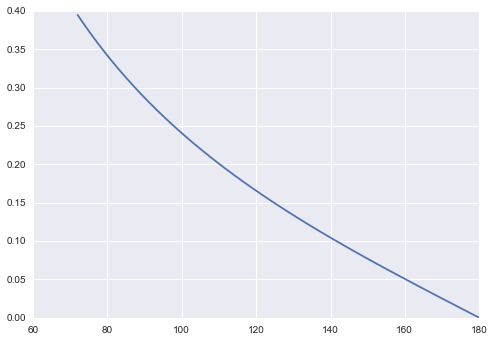

In [5]:
limit = 90.0 * 0.8
degrees = linspace(limit, 180.0, 101)
degrees2 = [deflection_at(i) for i in degrees]
mas = 60 * 60 * 1000 * (degrees2 - degrees)
plot(degrees, mas)

And my intiution was right! The deflection does not suddenly drop as the angle approaches the fraction 0.8 of the Earth’s limb (that is, ⅕ of the way below the horizon toward the nadir) — instead, the deflection is going up with no signs of stopping.

What would the deflection do as the object approaches the straight-down direction behind the Earth?

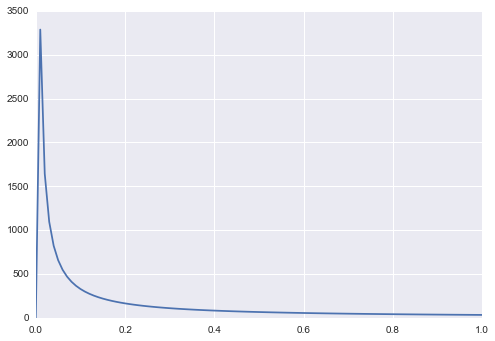

In [6]:
degrees = linspace(0.0, 1.0, 101)
degrees2 = [deflection_at(i) for i in degrees]
mas = 60 * 60 * 1000 * (degrees2 - degrees)
plot(degrees, mas)

The deflection becomes very great as the object approaches the point directly behind the Earth’s center — presumably because the equations are modeling the Earth as a point mass, and are imagining the light ray coming closer and closer to that infinitely dense point mass and being deflected to a greater and greater extend.

To circle back to the topic of this section: why 0.8? My guess is that they wanted to wait and not have the discontinuity until the object is low enough beneath the limb to be beneath the threshold of astronomical twilight, the lowest-angle event that (I think?) they publish in the Almanac. For most other objects they look only for rising and setting, but for the sun:

> http://aa.usno.navy.mil/faq/docs/RST_defs.php
>
> Astronomical twilight is defined to begin in the morning, and to end in the evening when the center of the Sun is geometrically 18 degrees below the horizon.

As 18° below the sun is exactly 20% of the way towards 90°, it looks like they cut this a bit close — they, essentially, wind up trying to do a zero-crossing search against the exact moment where a discontinuity exists? — but it makes sense of why they waited until the nadir angle reached 0.8 before pulling the effect out of their calculations.

# So — doesn’t the USNO approach create a step function?

Let’s choose an aribtrary Earth observer, the Lowell observatory, and its view of Mars, which is currently just pass opposition. What does one day’s worth of right ascension look like for Mars?

In [7]:
mars = novas.make_object(0, 4, 'Mars', None)

latitude = 35.2029
longitude = -111.6646
height = 2210  # meters
temperature = 25.0
pressure = 0.0
lowell = novas.make_on_surface(latitude, longitude, height, temperature, pressure)

def mars_radec(hour):
    jd_tt = novas.julian_date(2016, 7, 2, hour)
    ra, dec, dis = novas.topo_planet(jd_tt, 0.0, mars, lowell)
    return ra, dec

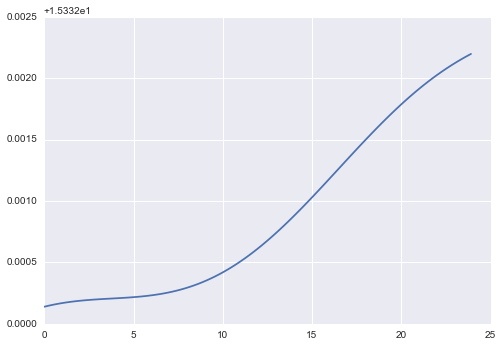

In [8]:
hour = linspace(0.0, 23.9, 101)
ra = [mars_radec(h)[0] for h in hour]
plot(hour, ra)

From a distance the curve looks very smooth. But if my reading of the UNSO code is correct, then it has a sharp discontinuity at the sub-milliarcsecond level around the moments that its nadir angle reaches 0.8 of the size of the Earth’s disc. When in that day did Mars cross the threshold of being `0.8 * pi` away from the center of the Earth from the point of view of the Lowell Observatory?

In [9]:
earth = novas.make_object(0, 3, 'Earth', None)
lowell2 = novas.make_observer_on_surface(
    latitude, longitude, height, temperature, pressure)

def to_vector(ra, dec, dis):
    ra = pi / 12.0 * ra
    dec = pi / 180.0 * dec
    x = dis * cos(dec) * cos(ra)
    y = dis * cos(dec) * sin(ra)
    z = dis * sin(dec)
    return x, y, z

def nadir_angle(hour):
    jd_tt = novas.julian_date(2016, 7, 2, hour)
    lowell_pos, lowell_vel = novas.geo_posvel(jd_tt, 0.0, lowell2)
    ra, dec, dis = novas.astro_planet(jd_tt, mars)
    mx, my, mz = to_vector(ra, dec, dis)
    limb_angle, nadir_angle = novas.limb_angle((mx, my, mz), lowell_pos)
    return nadir_angle

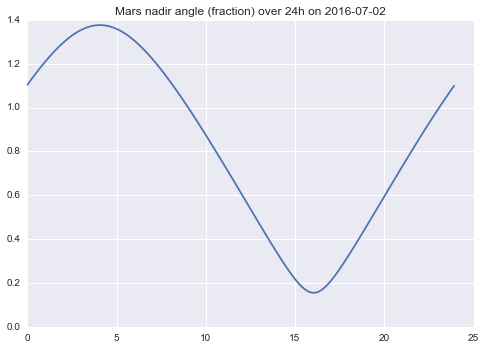

In [10]:
nadir = array([nadir_angle(h) for h in hour])
plot(hour, nadir)
title('Mars nadir angle (fraction) over 24h on 2016-07-02')

So Mars comes about 40% above the horizon. At what moments is its nadir angle at about 0.8?

In [11]:
indexes, = nonzero(numpy.diff(numpy.sign(nadir - 0.8)))
crossings = hour[indexes]
print indexes
print crossings

[44 89]
[ 10.516  21.271]


It looks like the curve crosses 0.8 somewhere between hour 10 and hour 11. If we now compute differences across a very detailed day’s worth of right ascensions looking for a discontinuity — a moment when its derivative suddenly jumps — will we find it at the same places that we estimated its nadir angle fraction to be 0.8?

In [12]:
# Takes several seconds to run:

hour_highres = linspace(0.0, 23.9, 100000)
values = [mars_radec(h)[0] for h in hour_highres]

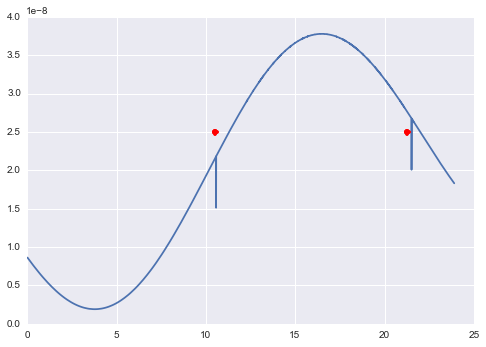

In [13]:
plot(hour_highres[:-1], np.diff(values))
plot(crossings, [2.5e-8] * len(crossings), 'ro')

Yes!

Our supposition was correct. We were not misreading the USNO code. It takes an effect that, as they compute it, would only increase in magnitude towards the center of the Earth, and simply cut it off 20% of the way from the edge of the Earth’s disc towards its center. (Where, for more observers, the disc takes up half of the sky.)

While in the future I might try to veer Skyfield away from this behavior because of the discontinuity, I will always want to be able at least to replicate it, so let's choose a few points from around the moment of discontinuity and try to capture them for a test.

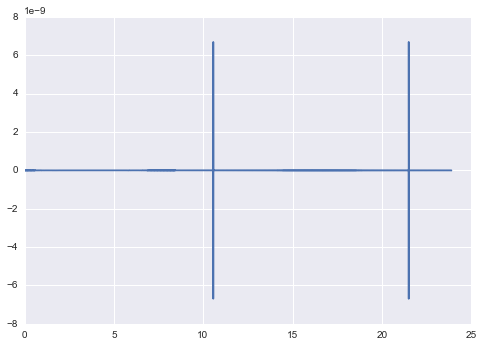

In [14]:
# The second derivative should make those spikes obvious.

d = diff(values)
d2 = diff(d)
plot(hour_highres[:-2], d2)

In [15]:
ivec, = nonzero(d2 < -2e-9)
print ivec

[44196 89992]


In [16]:
# We will test the 5 points around the first point.

i = ivec[0]
hours = hour_highres[i-1:i+5]
hours

array([ 10.56271063,  10.56294963,  10.56318863,  10.56342763,
        10.56366664,  10.56390564])

In [17]:
ra = [mars_radec(h)[0] for h in hours]
ra

[15.33246752170182,
 15.332467543516957,
 15.332467565334175,
 15.332467580459777,
 15.332467602277694,
 15.33246762409769]

Did we capture it? Is this the moment that the derivative changes?

In [18]:
diff(ra)

array([  2.18151364e-08,   2.18172183e-08,   1.51256021e-08,
         2.18179164e-08,   2.18199965e-08])

Yes! The center derivative is clearly smaller than the others.